In [27]:
# Domain [mm]
x_max = 1

using QuadGK
using Interpolations

# Elliptic extension of a vessel
function vessel(t)
    # Straight line parameters and starting point
    line_len = 1/4
    start_pos = 1/4
    # Ellipse curve parameters
    x_semiax = x_max - start_pos*x_max
    y_semiax = x_max - line_len*x_max
    max_t = 2 
    # when straight line
    if t < line_len*x_max
        return (start_pos*x_max, t)
    end
    # else, the ellipse
    tt = t - line_len*x_max
    ellipse_curve(tt) = (-x_semiax*cos(tt) + x_semiax, y_semiax*sin(tt))
    # We seek to obtain the parametrization with speed one.
    curve_deriv(tt) = (x_semiax*sin(tt), y_semiax*cos(tt))
    deriv_norm(tt) = sqrt(curve_deriv(tt)[1]^2 + curve_deriv(tt)[2]^2)
    arclength(tt) = quadgk(deriv_norm, 0, tt)
        # we invert the arclength
    t_sample = [t for t = linspace(0,max_t,1000)]
    arclength_sample = [arclength(t)[1] for t in t_sample]
    inv_interp = LinearInterpolation(arclength_sample, t_sample)
    natural_curve(tt) = ellipse_curve(inv_interp(tt))
    x0 = start_pos*x_max
    y0 = line_len*x_max
    return (natural_curve(tt)[1] + x0, natural_curve(tt)[2] + y0) 
end

using Roots

target_funct(t) = max(vessel(t)[1] - x_max*0.9, vessel(t)[2] - x_max*0.9)
impossible_time = 1.5
lower_time = 0
if target_funct(lower_time)*target_funct(impossible_time) > 0
    print("This is not going to work")
end
t_max = find_zero(target_funct, (lower_time, impossible_time), Bisection())


vessel (generic function with 1 method)

# Bruillon grounds ahead, thread carefully

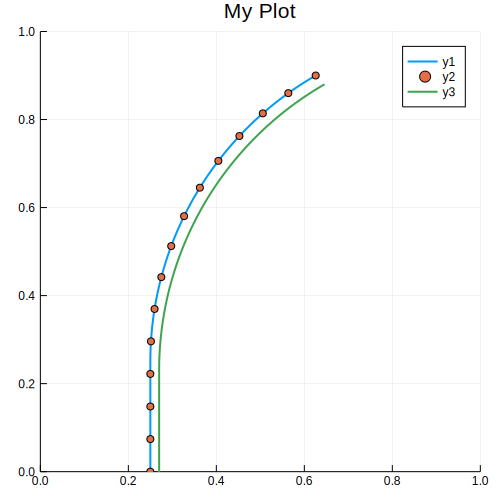

In [40]:
# Plotting cell
T = linspace(0,t_max,1000)
Y = [vessel(t) for t in T]
Yx = [Y[j][1] for j in 1:length(Y)]
Yy = [Y[j][2] for j in 1:length(Y)]

using Plots
plot(Yx,Yy,linewidth=2,title="My Plot" , xlims = (0,x_max), ylims = (0,x_max), size = (500,500))

T = linspace(0,t_max, 15)
Y = [vessel(t) for t in T]
Yx = [Y[j][1] for j in 1:length(Y)]
Yy = [Y[j][2] for j in 1:length(Y)]
plot!(Yx,Yy, seriestype=:scatter)

# Testing by displacing the curve
dx = 0.02
T = linspace(0,t_max,1000)
Y = [vessel(t) for t in T]
Yx = [Y[j][1] + dx for j in 1:length(Y)]
Yy = [Y[j][2] - dx for j in 1:length(Y)]
plot!(Yx,Yy, linewidth=2)

In [21]:
# Trying to integrate the curvature such that the step is constant. 

using QuadGK
vessel_norm(t) = sqrt(vessel(t)[1]^2 + vessel(t)[2]^2)
s(t) = quadgk(vessel_norm,0.25, t)
s(1)[1]
s(2)[1]

1.673737650147885

In [26]:
using Interpolations
tt = [t for t = linspace(0,1,1000)]
st = [s(t)[1] for t in tt]
interp = LinearInterpolation(tt,st)
interp(0.5)
interp(0.6)

0.16257557775815573

In [35]:
# Find the maximum relevant time, when we are getting too close to the boundary.
using Roots

target_funct(t) = max(vessel(t)[1] - x_max*0.9, vessel(t)[2] - x_max*0.9)
impossible_time = 1.5
lower_time = 0
if target_funct(lower_time)*target_funct(impossible_time) > 0
    print("This is not going to work")
end
t_max = find_zero(target_funct, (lower_time, impossible_time), Bisection())

1.036361128741636